<a href="https://colab.research.google.com/github/xtheslayer666/mi_seminar/blob/main/Person_Identification_LF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung Person Identification mit LSTM und SVM von Lukas Faust

In folgender Übung sollt ihr die Inhalte aus des Vortrags selbst nachstellen können.



Install OpenPose

In [1]:
%cd /content/
!git clone -l -s git://github.com/knoeferl/mi_seminar_uebung.git mi_seminar_uebung
%cd /content/mi_seminar_uebung
!ls

/content
Cloning into 'mi_seminar_uebung'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 38 (delta 14), reused 13 (delta 4), pack-reused 0
Receiving objects: 100% (38/38), 8.69 MiB | 14.16 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/mi_seminar_uebung
extract_features.py
helper.py
Kopie_von_uebung_Action_Recognition_von_Michael_Knöferl.ipynb
model.pth
mydataset.h5
preprocessing.py
README.md
uebung_Action_Recognition_Eval_von_Michael_Knöferl.ipynb
uebung_Action_Recognition_von_Michael_Knöferl.ipynb


In [2]:
import os
from os.path import exists, join, basename, splitext
from IPython.display import clear_output

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  !apt-get update
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
clear_output()


In [3]:
!pip3 install torch torchvision
!pip3 install torchnet
clear_output()

In [4]:
!git clone https://github.com/rokibulislaam/colab-ffmpeg-cuda.git
!cp -r ./colab-ffmpeg-cuda/bin/. /usr/bin/
!ffmpeg -version
clear_output()

In [5]:
import os
import numpy as np
import h5py

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
import torchnet as tnt
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
use_cuda = torch.cuda.is_available()
print('use cuda: %s'%(use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
import torchvision.models.inception as inception



use cuda: True



###Datensatz
Wie im Vortrag erwähnt besteht der Datensatz das die bereits mit Openpose vor verarbeitet wurden und die entsprechenden Features wurde bereits extrahiert.

Es sind 3 Features pro Bild für 15 Bilder und wir laden immer 15 Stück als ein Batch ein.

Beim Laden werden die Daten gleich in einen Trainings- und einen Validierungsdatensatz aufgeteilt

In [6]:
class Dataset(DD.Dataset):
    def __init__(self, data_path, name='dataset'):
        super(Dataset, self).__init__()
        self.data_path = os.path.join(data_path, '%s.h5'%name)

        with h5py.File(self.data_path) as f:
            self.data = np.array(f['seq'])
            self.label = np.array(f['name_label'])

        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        label = int(self.label[index])
        sample = {'seq': seq, 'name_label': label}
        return sample

    def __len__(self):
        return self.num_sequences


dataset = Dataset('./', name='mydataset')
batch_size = 15
validation_split = .2
shuffle_dataset = True
random_seed= 42


dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trLD = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                   sampler=train_sampler)
valLD = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                    sampler=valid_sampler)
input_dim = dataset.n_dim
num_class = 6
dim = batch_size * dataset.n_dim

##Anzahl der Features

In [7]:
print(dataset.n_dim)

45


##Länge einer Sequenzen

In [8]:
print(dataset.seq_len)

15


##Anzahl der Sequenzen

In [9]:
print(dataset.num_sequences)

995


##LSTM

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)

class SequenceClassify(nn.Module):
    def __init__(self, dim, batch_size):
        super(SequenceClassify, self).__init__()
        self.recurrent_layer = nn.LSTM(45, 7, 1)
        self.project_layer = nn.Linear(7, num_class)
        ###################################################
    def forward(self, input1, h_t_1=None, c_t_1=None):
        lstm_input = input1
        rnn_outputs, (hn, cn) = self.recurrent_layer(lstm_input)        
        logits = self.project_layer(rnn_outputs[:,-1])
        return logits
    
model = SequenceClassify(dim, batch_size)    
if torch.cuda.is_available():
  model = SequenceClassify(dim, batch_size).cuda()



##Optimizer wahl

In [11]:
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
optimizer = torch.optim.Adadelta(model.parameters(), lr = 1e-1)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# run the model for one epoch
# can be used for both training or validation model

In [12]:
def run_epoch(data_loader, model, criterion, epoch, is_training, optimizer=None):
    if is_training:
        model.train()
        logger_prefix = 'train'
    else:
        model.eval()
        logger_prefix = 'val'

    confusion_matrix = tnt.meter.ConfusionMeter(num_class)
    acc = tnt.meter.ClassErrorMeter(accuracy=True)
    meter_loss = tnt.meter.AverageValueMeter()

    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['name_label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        input_label_var = Variable(label).type(LongTensor)
        # compute output
        # output_logits: [batch_size, num_class]
        output_logits = model(input_sequence_var)
        loss = criterion(output_logits, input_label_var)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        meter_loss.add(loss.item())
        acc.add(output_logits.data, input_label_var.data)
        confusion_matrix.add(output_logits.data, input_label_var.data)

    #print('%s Epoch: %d  , Loss: %.4f,  Accuracy: %.2f'%(logger_prefix, epoch, meter_loss.value()[0], acc.value()[0]))
    if logger_prefix == 'val':
        val_loss.append(meter_loss.value()[0])
        val_accuracy.append(acc.value()[0])
    else:
        train_loss.append(meter_loss.value()[0])
        train_accuracy.append(acc.value()[0])
    return acc.value()[0]

global val_loss, val_accuracy, train_loss, train_accuracy, num_epochs
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []
num_epochs = 501
evaluate_every_epoch = 1

for e in range(num_epochs):
    print("Epoche " + str(e) + " of " + str(num_epochs))
    run_epoch(trLD, model, criterion, e, True, optimizer)
    if e % evaluate_every_epoch == 0:
        run_epoch(valLD, model, criterion, e, False, None)   

PATH = "/content/mi_seminar_uebung/model.pth"
torch.save(model.state_dict(), PATH)

clear_output()

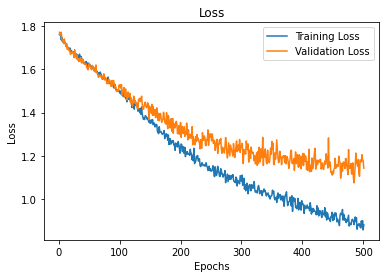

In [13]:
epochs = []
for i in range(1, num_epochs+1):
    epochs.append(i)
import matplotlib.pyplot as plt
%matplotlib inline
plot1 = plt.plot(epochs, train_loss)
plot2 = plt.plot(epochs, val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"], loc = 1)
plt.show()

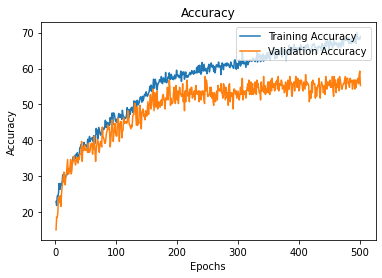

In [14]:
epochs = []
for i in range(1, len(train_accuracy)+1):
    epochs.append(i)
plot3 = plt.plot(epochs, train_accuracy)
plot4 = plt.plot(epochs, val_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"], loc = 1)
plt.show()

<Figure size 720x720 with 0 Axes>

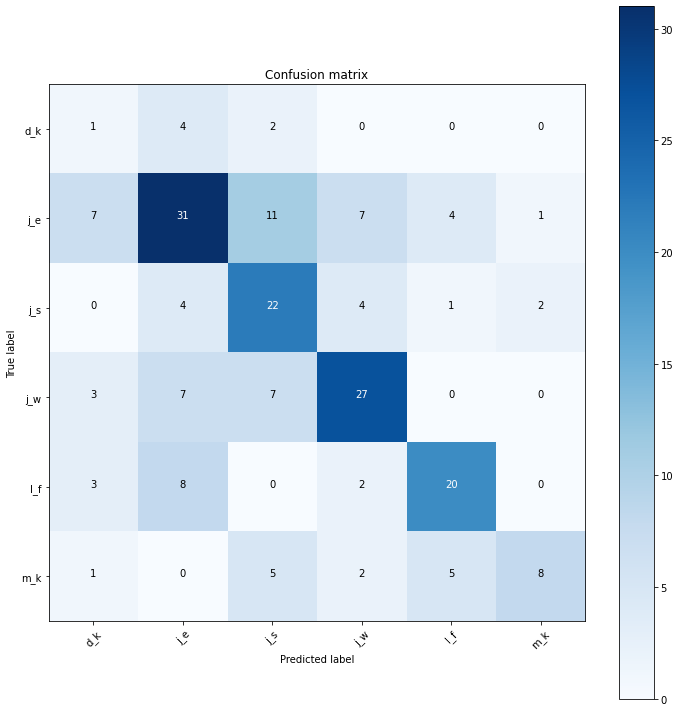

<Figure size 720x720 with 0 Axes>

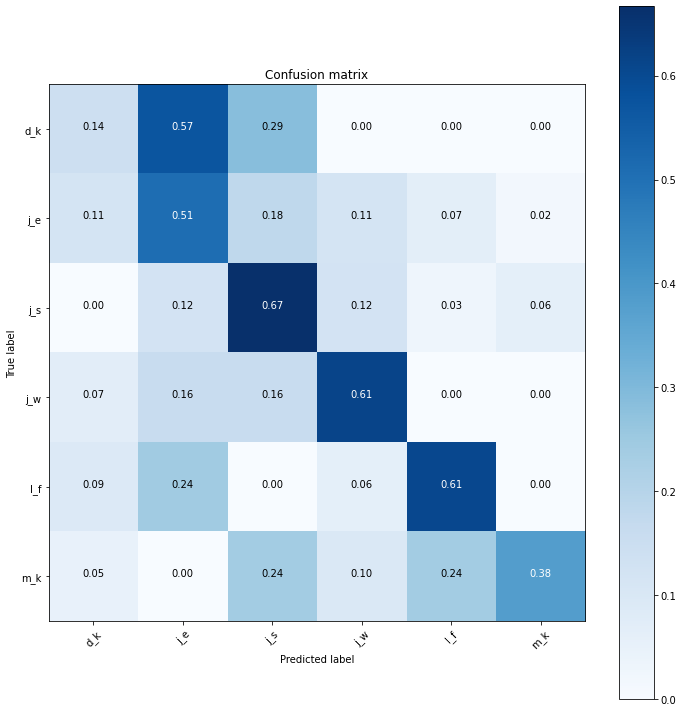

In [15]:
def predict_on_test(model, data_loader):
    model.eval() # Model wird in evaluierungs modus gebracht
    results=open("results.csv",'w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    all_preds = list()
    all_labels = list()
    for batch_idx, sample in enumerate(data_loader):
        sequence = sample['seq']
        label = sample['name_label']
        input_sequence_var = Variable(sequence).type(FloatTensor)
        scores = model(input_sequence_var)
        _, preds = scores.data.max(1)
        all_preds = np.append(all_preds, preds.cpu())
        all_labels = np.append(all_labels, label)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
 
    all_preds = torch.from_numpy(all_preds.astype(int))
    all_labels = torch.from_numpy(all_labels.astype(int))
    stacked = torch.stack((all_labels, all_preds), dim=1 )

    cmt = torch.zeros(6,6, dtype=torch.int64)
    for p in stacked:
      tl, pl = p.tolist()
      cmt[tl, pl] = cmt[tl, pl] + 1
    return cmt


import itertools
import numpy as np
import matplotlib.pyplot as plt
from helper import plot_confusion_matrix




cm = predict_on_test(model, valLD)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k'])
print()
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k'], normalize=True)

In [16]:
!wget -cq https://github.com/xtheslayer666/mi_seminar/raw/main/l_f_squat_2.mp4

In [17]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('/content/mi_seminar_uebung/l_f_squat_2.mp4', width=960, height=720)

Openpose erstellt json files mit den erkannten Informationen und erstellt ein Video in dem diese dargestellt werden.

In [18]:
if True:
  !ffmpeg -y -loglevel info -i /content/mi_seminar_uebung/l_f_squat_2.mp4 /content/mi_seminar_uebung/openpose/examples/media/video.avi 

  !rm /content/mi_seminar_uebung/openpose.avi
  !cd /content/mi_seminar_uebung/openpose && ./build/examples/openpose/openpose.bin --video examples/media/video.avi --write_json /content/mi_seminar_uebung/ --display 0 --write_video /content/mi_seminar_uebung/openpose.avi --face --hand

  import subprocess
  video_input = 'examples/media/video.mp4'
  json_folder = '/content/mi_seminar_uebung'
  avi_ = "/content/mi_seminar_uebung/openpose.avi"

  !ffmpeg -y -loglevel info -i /content/mi_seminar_uebung/temp/openpose.avi /content/mi_seminar_uebung/temp/output.mp4
  clear_output()

In [19]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
from extract_features import create_json_and_mp4
from helper import ReadFromVideo, VideoWriter, ImageDisplayer, draw_scores_onto_image
from preprocessing import preapareDataOfFolder


class Dataset(DD.Dataset):
    def __init__(self, data):
        super(Dataset, self).__init__()

        self.data = np.array(data)
        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        return seq

    def __len__(self):
        return self.num_sequences


num_class = 6



PATH = "/content/mi_seminar_uebung/model.pth"

use_cuda = torch.cuda.is_available()
# use_cuda = False
print('use cuda: %s' % (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

batch_size = 15
dim = 675
model = SequenceClassify(dim, batch_size)
if use_cuda:
    model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

filename = 'video_out.avi'
mp4_file = '/content/mi_seminar_uebung/openpose.avi'
json_folder = '/content/mi_seminar_uebung/'
name_labels = []
labels = []
label_list = ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k']
name_label_list = []
result = []
name_labels, labels, label_list, name_label_list, result = preapareDataOfFolder(json_folder, name_labels, labels,
                                                                                label_list, name_label_list, result)
label_list = ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k']
dataset = Dataset(result)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

images_loader = ReadFromVideo(mp4_file)


DST_FOLDER = '/content/mi_seminar_uebung/'
DST_VIDEO_NAME = filename
DST_VIDEO_FPS = images_loader.get_fps()

video_writer = VideoWriter(DST_FOLDER + DST_VIDEO_NAME, DST_VIDEO_FPS)

all_scores = []
for batch_idx, sample in enumerate(data_loader):
    input_sequence_var = Variable(sample).type(FloatTensor)
    scores = model(input_sequence_var)
    sm = torch.nn.Softmax(dim=1)
    probabilities = sm(scores)
    all_scores.append(probabilities)


try:
    ith_img = -1
    while images_loader.has_image():
        img = images_loader.read_image()
        ith_img += 1
        img_disp = img.copy()
        draw_scores_onto_image(img_disp, all_scores[int(ith_img / (DST_VIDEO_FPS * batch_size))][
            int(ith_img / DST_VIDEO_FPS) % 15],
                               label_list)
        video_writer.write(img_disp)

finally:
    video_writer.stop()
    print("Program ends")

use cuda: True
Found:  180 json keypoint frame files
json files:  video_000000000058_keypoints.json
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/video_out.avi
Program ends


Finally, visualize the result:

In [20]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

!ffmpeg -y -loglevel info -i /content/mi_seminar_uebung/video_out.avi /content/mi_seminar_uebung/video_out.mp4
show_local_mp4_video('/content/mi_seminar_uebung/video_out.mp4', width=960, height=720)

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --enable-cuda-nvcc --enable-cuvid --enable-nvenc --enable-libnpp --enable-cuda-llvm --pkgconfigdir=/content/workspace/lib/pkgconfig --prefix=/content/workspace --pkg-config-flags=--static --extra-cflags='-I/content/workspace/include -I/usr/local/cuda/include' --extra-ldflags='-L/content/workspace/lib -L/usr/local/cuda/lib64' --extra-libs='-lpthread -lm' --enable-static --disable-debug --disable-shared --disable-ffplay --disable-doc --enable-openssl --enable-gpl --enable-version3 --enable-nonfree --enable-pthreads --enable-libvpx --enable-libmp3lame --enable-libopus --enable-libtheora --enable-libvorbis --enable-libx264 --enable-libx265 --enable-runtime-cpudetect --enable-libfdk-aac --enable-avfilter --enable-libopencore_amrwb --enable-libopencore_amrnb --enable-filters --enable-libvidstab --enable-libaom --enable-libsrt
  libavutil      56. 51.100 / 56. 5

##Support Vector Machine

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


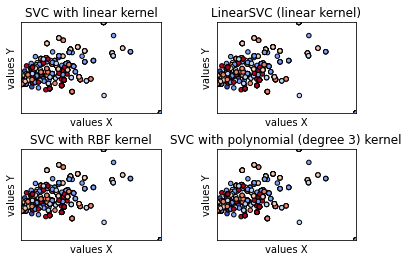

In [21]:

from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

import itertools
import numpy as np
import matplotlib.pyplot as plt
from helper import plot_confusion_matrix, make_meshgrid, plot_contours





with h5py.File('./mydataset.h5') as f:
        X = np.array(f['seq'])
        y = np.array(f['name_label'])

size = X.shape[0]
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)


C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C, max_iter=10000),
          svm.LinearSVC(C=C, max_iter=10000, tol=0.0001),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X_train, y_train) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# 2x2 grid Plot erstellen.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

#Daten in Dimension von 675 auf 2 verringern
pca = PCA(n_components=2)
X_r = pca.fit(X_train).transform(X_train)
X0, X1 = X_r[:,0],  X_r[:,1]
xx, yy = make_meshgrid(X0, X1)


for clf, title, ax in zip(models, titles, sub.flatten()):

    model_pred = clf.predict(X_test)

    poly_accuracy = accuracy_score(y_test, model_pred)
    poly_f1 = f1_score(y_test, model_pred, average='weighted')


    ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('values X')
    ax.set_ylabel('values Y')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

    all_preds = torch.from_numpy(model_pred.astype(int))
    all_labels = torch.from_numpy(y_test.astype(int))
    stacked = torch.stack((all_labels, all_preds), dim=1 )

    cmt = torch.zeros(6,6, dtype=torch.int64)
    for p in stacked:
      tl, pl = p.tolist()
      cmt[tl, pl] = cmt[tl, pl] + 1
plt.show()



Accuracy (  SVC with linear kernel  ):  77.39
F1 ( SVC with linear kernel ):  77.27
_________________________________________




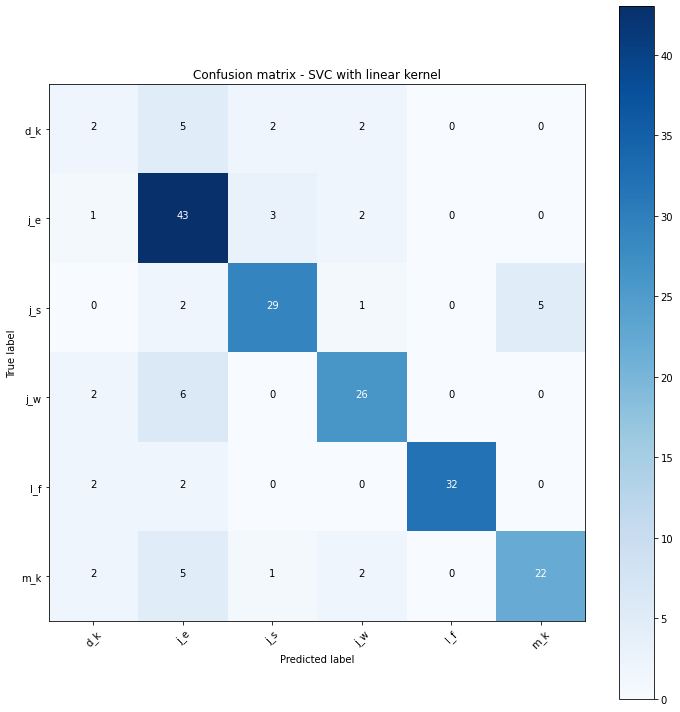

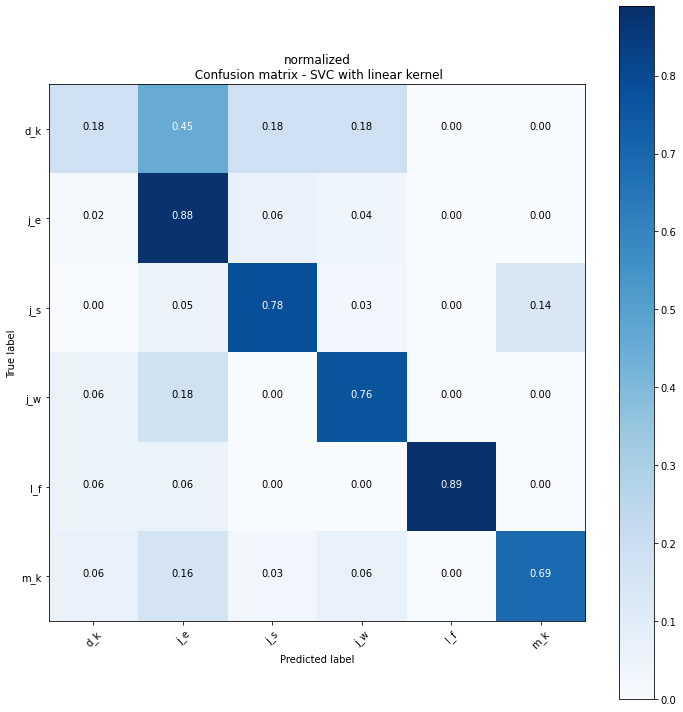

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy (  LinearSVC (linear kernel)  ):  75.38
F1 ( LinearSVC (linear kernel) ):  74.22
_________________________________________




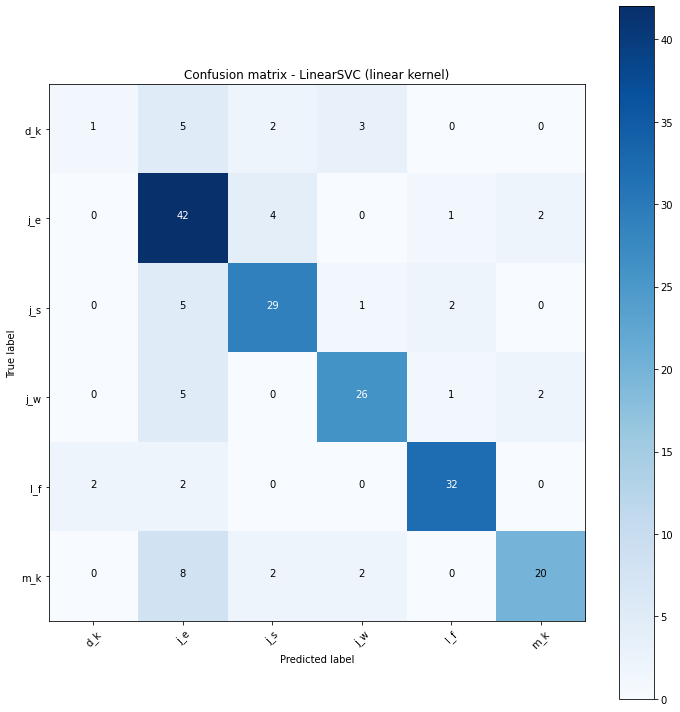

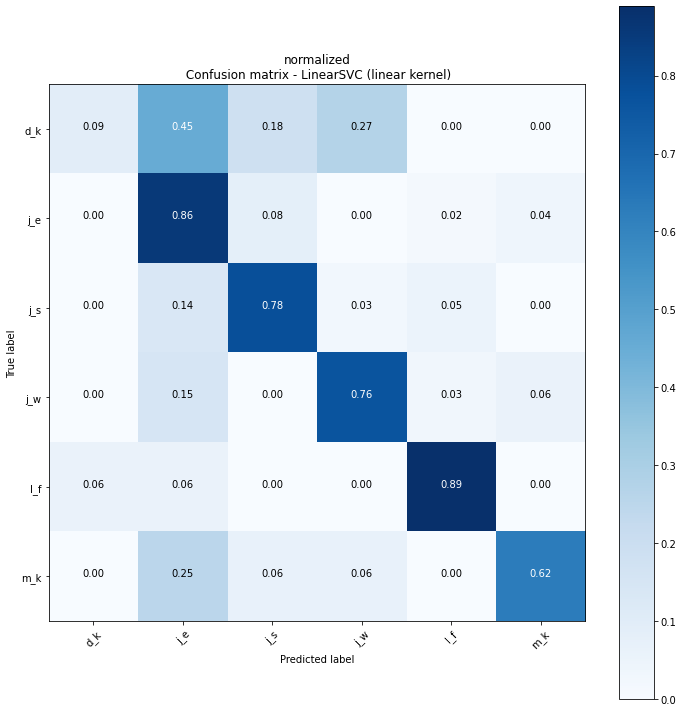

Accuracy (  SVC with RBF kernel  ):  74.87
F1 ( SVC with RBF kernel ):  74.62
_________________________________________




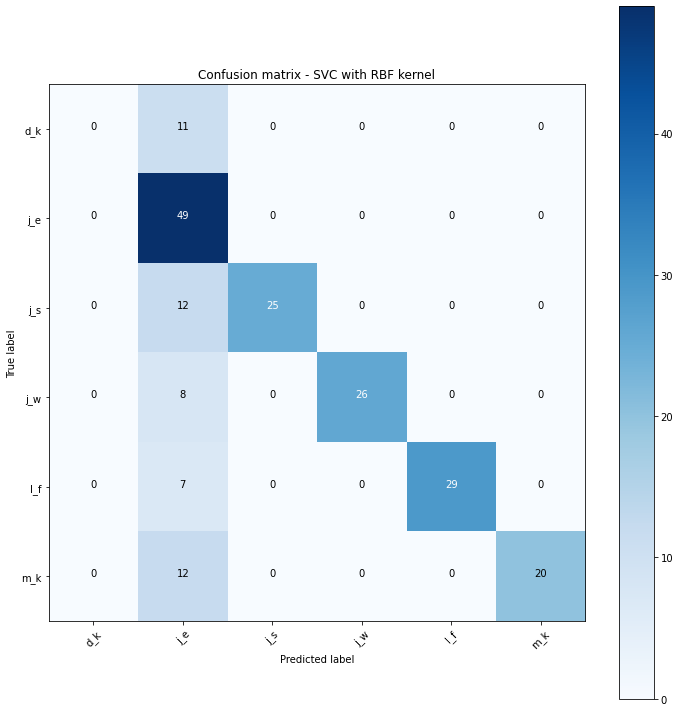

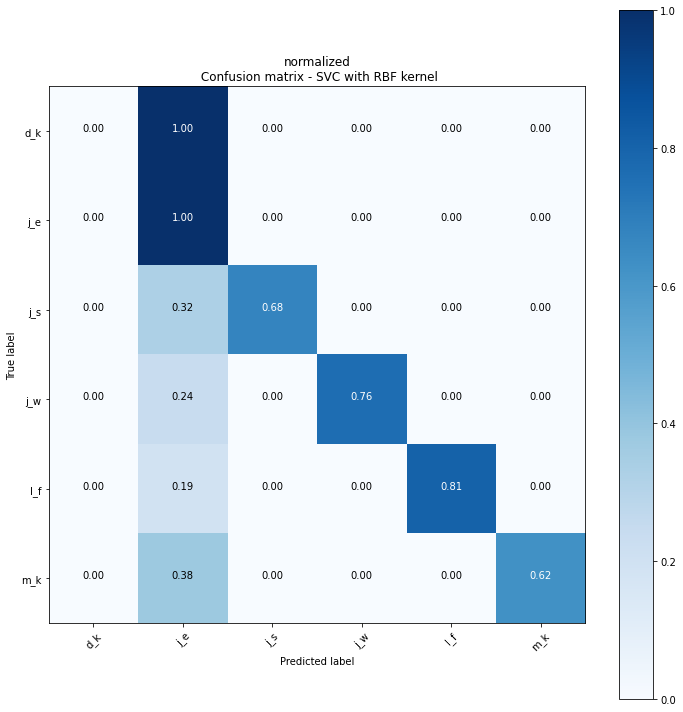

Accuracy (  SVC with polynomial (degree 3) kernel  ):  73.37
F1 ( SVC with polynomial (degree 3) kernel ):  74.46
_________________________________________




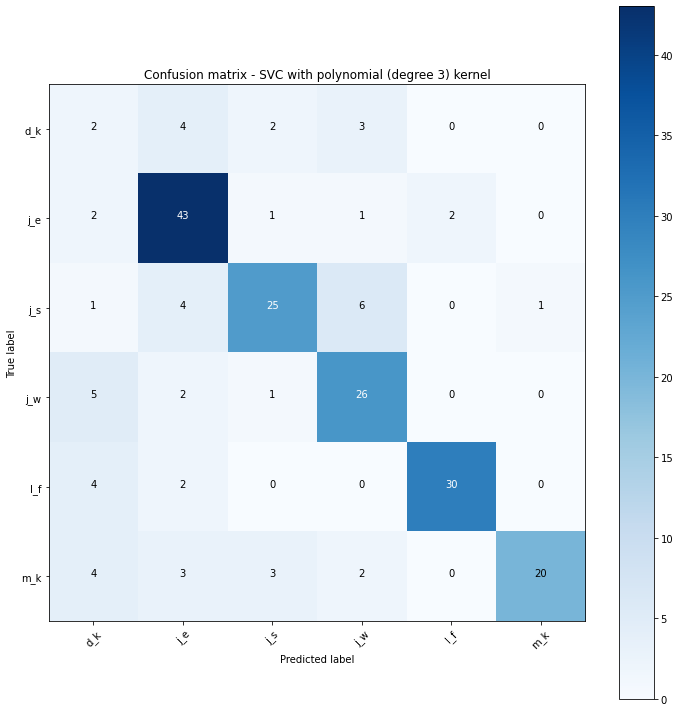

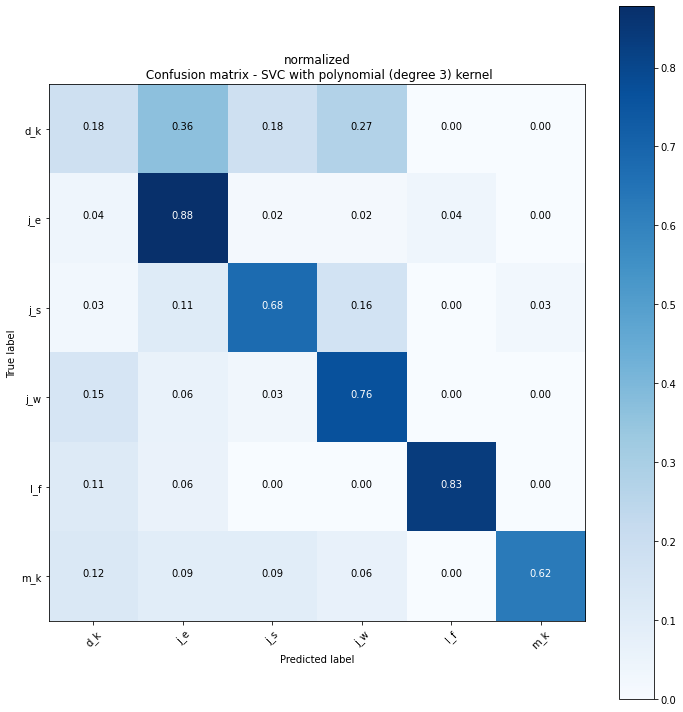

In [23]:
with h5py.File('./mydataset.h5') as f:
        X = np.array(f['seq'])
        y = np.array(f['name_label'])

size = X.shape[0]
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)


C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C, max_iter=10000),
          svm.LinearSVC(C=C, max_iter=10000, tol=0.0001),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X_train, y_train) for clf in models)

# title der Plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

for clf, title in zip(models, titles):
  model_pred = clf.predict(X_test)
  poly_accuracy = accuracy_score(y_test, model_pred)
  poly_f1 = f1_score(y_test, model_pred, average='weighted')
  print('Accuracy ( ', title ,' ): ', "%.2f" % (poly_accuracy*100))
  print('F1 (', title ,'): ', "%.2f" % (poly_f1*100))
  print('_________________________________________\n\n')



  all_preds = torch.from_numpy(model_pred.astype(int))
  all_labels = torch.from_numpy(y_test.astype(int))
  stacked = torch.stack((all_labels, all_preds), dim=1 )

  cmt = torch.zeros(6,6, dtype=torch.int64)
  for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

  plot_confusion_matrix(cmt, ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k'], title='Confusion matrix - ' + title )
  print()
  plot_confusion_matrix(cmt, ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k'], title='normalized\n Confusion matrix - ' + title, normalize=True)

In [24]:
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as DD
from extract_features import create_json_and_mp4
from helper import ReadFromVideo, VideoWriter, ImageDisplayer, draw_scores_onto_image
from preprocessing import preapareDataOfFolder
from sklearn import preprocessing

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

class Dataset(DD.Dataset):
    # subset can be: 'train', 'val', 'test'
    def __init__(self, data):
        super(Dataset, self).__init__()

        self.data = np.array(data)
        self.num_sequences = self.data.shape[0]
        self.seq_len = self.data.shape[1]
        self.n_dim = self.data.shape[2]

    def __getitem__(self, index):
        seq = self.data[index]
        return seq

    def __len__(self):
        return self.num_sequences


num_class = 6

PATH = "/content/mi_seminar_uebung/model.pth"

use_cuda = torch.cuda.is_available()
# use_cuda = False
print('use cuda: %s' % (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor



filename = 'video_out.avi'
mp4_file = '/content/mi_seminar_uebung/openpose.avi'
json_folder = '/content/mi_seminar_uebung/'
name_labels = []
labels = []
label_list = ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k']
name_label_list = []
result = []
name_labels, labels, label_list, name_label_list, result = preapareDataOfFolder(json_folder, name_labels, labels,
                                                                                label_list, name_label_list, result)
label_list = ['d_k', 'j_e', 'j_s', 'j_w','l_f','m_k']
dataset = Dataset(result)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)


# img_displayer = ImageDisplayer()

with h5py.File('./mydataset.h5') as f:
        X = np.array(f['seq'])
        y = np.array(f['name_label'])

size = X.shape[0]
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)




# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C, max_iter=10000),
          svm.LinearSVC(C=C, max_iter=10000, tol=0.0001),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X_train, y_train) for clf in models)

# title for the plots
titles = ('linear',
          'lineark',
          'RBF',
          'SVC')

result_videos = []

for clf, title in zip(models, titles):
    images_loader = ReadFromVideo(mp4_file)
    DST_FOLDER = '/content/mi_seminar_uebung/'
    DST_VIDEO_NAME = filename
    DST_VIDEO_FPS = images_loader.get_fps()
    DST_VIDEO_PATH = DST_FOLDER + title + DST_VIDEO_NAME
    video_writer = VideoWriter(DST_VIDEO_PATH, DST_VIDEO_FPS)


    lb = preprocessing.LabelBinarizer()
    lb.fit(range(num_class))

    all_scores = []
    for batch_idx, X in enumerate(data_loader):
        X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
        scores = clf.predict(X)
        labeled_scores = lb.transform(scores.astype(int))
        all_scores.append(labeled_scores)


    try:
        ith_img = -1
        while images_loader.has_image():
            # -- Read image
            img = images_loader.read_image()
            ith_img += 1
            img_disp = img.copy()
            draw_scores_onto_image(img_disp, all_scores[int(ith_img / (DST_VIDEO_FPS * batch_size))][
            int(ith_img / DST_VIDEO_FPS) % 15],
                                  label_list)

            video_writer.write(img_disp)

    finally:
        video_writer.stop()
        

    DST_VIDEO_PATH_FINAL = DST_VIDEO_PATH + '.mp4'
    if os.path.exists(DST_VIDEO_PATH_FINAL):
      os.remove(DST_VIDEO_PATH_FINAL)

    subprocess.run('ffmpeg -y -loglevel info -i ' + DST_VIDEO_PATH + ' '+ DST_VIDEO_PATH_FINAL, shell=True, capture_output=True, check=True )
    result_videos.append(DST_VIDEO_PATH_FINAL)

use cuda: True
Found:  180 json keypoint frame files
json files:  video_000000000058_keypoints.json
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/video_out.avi
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/linearvideo_out.avi


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/linearvideo_out.avi
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/linearkvideo_out.avi
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/linearkvideo_out.avi
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/RBFvideo_out.avi
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/RBFvideo_out.avi
Complete writing 30.0fps and 6.0s video to /content/mi_seminar_uebung/SVCvideo_out.avi


In [25]:
show_local_mp4_video(result_videos[0], width=960, height=720)

In [26]:
show_local_mp4_video(result_videos[1], width=960, height=720)

In [27]:
show_local_mp4_video(result_videos[2], width=960, height=720)

In [28]:
show_local_mp4_video(result_videos[3], width=960, height=720)